# Project 1: Real / Fake image detection

# Google Mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [2]:
import os
import random
import shutil
import fnmatch
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import string

# Data Importing

In [3]:
fake_files = os.listdir('/content/drive/MyDrive/Project DNN/F_NN_PRO/data/real_and_fake_face_detection/real_and_fake_face/training_fake')
real_files = os.listdir('/content/drive/MyDrive/Project DNN/F_NN_PRO/data/real_and_fake_face_detection/real_and_fake_face/training_real')

In [4]:
root_dir = '/content/drive/MyDrive/Project DNN/F_NN_PRO/data/real_and_fake_face_detection/real_and_fake_face/'
new_root = 'all/'
classes = ['training_fake', 'training_real']

# Create train / test / val folders
for cls in classes:
    if os.path.exists(root_dir + new_root+ 'train/' + cls.split("_")[1]) == False:
        os.makedirs(root_dir + new_root+ 'train/' + cls.split("_")[1])
    if os.path.exists(root_dir +new_root + 'test/' + cls.split("_")[1]) == False:
        os.makedirs(root_dir +new_root + 'test/' + cls.split("_")[1])
    if os.path.exists(root_dir +new_root +'val/' + cls.split("_")[1]) == False:
        os.makedirs(root_dir +new_root +'val/' + cls.split("_")[1])

# Create partition of the data after shuffling
for cls in classes:
    src = root_dir + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)

    # 0.70 = training ratio , 0.20 = test ratio, 0.10 = validation ratio
    train_FileNames, test_FileNames, val_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames)*0.70),int(len(allFileNames)*0.90)])

    # Convert file names from array to list

    train_FileNames = [src+'/'+ name for name in train_FileNames]
    val_FileNames = [src+'/' + name for name in val_FileNames]
    test_FileNames = [src+'/' + name for name in test_FileNames]

    print("----------\n")
    print(cls.split("_")[1])
    print('Total images  : '+str(len(allFileNames)))
    print('Training : '+str(len(train_FileNames)))
    print('Testing : '+str(len(test_FileNames)))
    print('Validation : '+str(len(val_FileNames)))

    # Copy paste images to target directory

    for name in train_FileNames:
        shutil.copy(name, root_dir + new_root+'train/'+cls.split("_")[1])

    for name in test_FileNames:
        shutil.copy(name,root_dir + new_root+'test/'+cls.split("_")[1] )

    for name in val_FileNames:
        shutil.copy(name, root_dir +new_root+'val/'+cls.split("_")[1] )

print("----------\n")
print(new_root.split("/")[0])
print("Total images : "+ str(len([f for path, subdirs, files in os.walk(root_dir + new_root) for f in files])))
print("Training : "+ str(len([f for path, subdirs, files in os.walk(root_dir + new_root+'train/') for f in files])))
print("Testing : "+ str(len([f for path, subdirs, files in os.walk(root_dir + new_root+'test/') for f in files])))
print("Validation : "+ str(len([f for path, subdirs, files in os.walk(root_dir + new_root+'val/') for f in files])))

----------

fake
Total images  : 960
Training : 672
Testing : 192
Validation : 96
----------

real
Total images  : 1081
Training : 756
Testing : 216
Validation : 109
----------

all
Total images : 4477
Training : 2040
Testing : 1480
Validation : 957


# Exploratory Data Analysis

In [5]:
# Set root directory
ROOT_DIR = '/content/drive/MyDrive/Project DNN/F_NN_PRO/data/real_and_fake_face_detection/real_and_fake_face/'
NEW_ROOT = 'all/'

CLASSES = ['training_fake', 'training_real']

## Data Instances

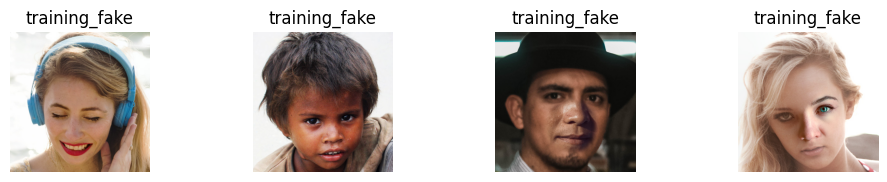

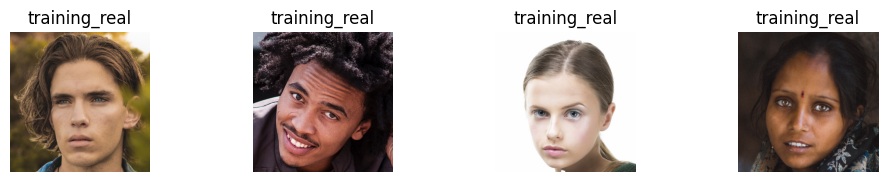

TRAIN SET
Number of fake images: 959
Number of real images: 1081

TEST SET
Number of fake images: 695
Number of real images: 785

VAL SET
Number of fake images: 443
Number of real images: 514



In [6]:
import matplotlib.pyplot as plt
import os

def display_images(images, titles=None, cols=4, figsize=(15, 15)):
    rows = len(images) // cols + 1
    plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
    plt.show()

def visualize_sample_images(root_dir, class_names, n_samples=4):
    for cls in class_names:
        dir_path = os.path.join(root_dir, 'train', cls.split("_")[1])
        image_files = os.listdir(dir_path)[:n_samples]
        images = [plt.imread(os.path.join(dir_path, file)) for file in image_files]
        display_images(images, titles=[cls] * len(images), cols=n_samples, figsize=(12, 4))

def dataset_distribution(root_dir, subsets):
    for subset in subsets:
        print(f"{subset.upper()} SET")
        for cls in CLASSES:
            dir_path = os.path.join(root_dir, subset, cls.split("_")[1])
            num_images = len(os.listdir(dir_path))
            print(f"Number of {cls.split('_')[1]} images: {num_images}")
        print()

# Set the path to directory for the new structure
ROOT_DIR_NEW = '/content/drive/MyDrive/Project DNN/F_NN_PRO/data/real_and_fake_face_detection/real_and_fake_face/all/'


# Visualize some images and display dataset distribution
visualize_sample_images(ROOT_DIR_NEW, CLASSES)
dataset_distribution(ROOT_DIR_NEW, ['train', 'test', 'val'])


## Color Distribution: Fake Images

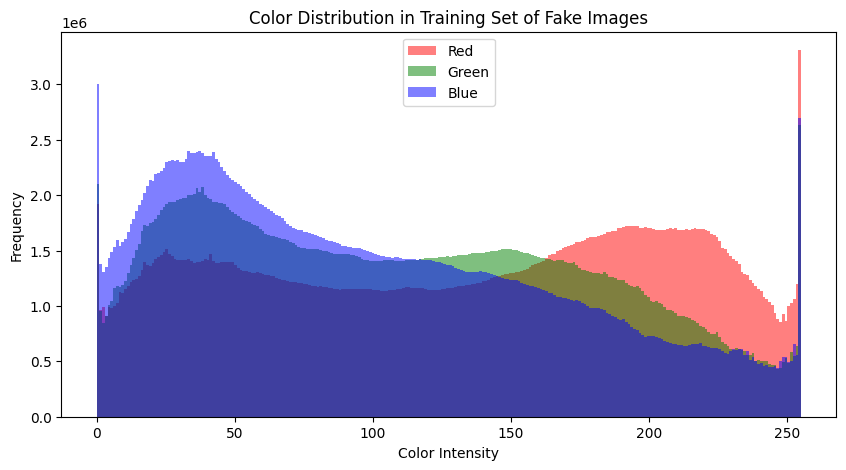

Mean of Color Channels: [131.9266991  110.76706372  99.61667648]
Standard Deviation of Color Channels: [74.07391311 68.25841445 67.75960674]


In [7]:
def get_image_colors(dataset_path):
    colors = []
    for img_name in os.listdir(dataset_path):
        img_path = os.path.join(dataset_path, img_name)
        try:
            img = io.imread(img_path)
            # for grayscale images: skip those or handle differently
            if img.ndim == 3:
                colors.append(img.reshape(-1, img.shape[-1]))
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return np.concatenate(colors, axis=0)

FAKE_DIR = '/content/drive/MyDrive/Project DNN/F_NN_PRO/data/real_and_fake_face_detection/real_and_fake_face/all/train/fake/'

image_colors = get_image_colors(FAKE_DIR)

plt.figure(figsize=(10, 5))
plt.hist(image_colors[:, 0], bins=256, alpha=0.5, color='red', label='Red')
plt.hist(image_colors[:, 1], bins=256, alpha=0.5, color='green', label='Green')
plt.hist(image_colors[:, 2], bins=256, alpha=0.5, color='blue', label='Blue')
plt.xlabel('Color Intensity')
plt.ylabel('Frequency')
plt.title('Color Distribution in Training Set of Fake Images')
plt.legend()
plt.show()

# Calculate the mean and standard deviation for each channel
channel_means = np.mean(image_colors, axis=0)
channel_stds = np.std(image_colors, axis=0)

print("Mean of Color Channels:", channel_means)
print("Standard Deviation of Color Channels:", channel_stds)


## Color Distribution: Real Images

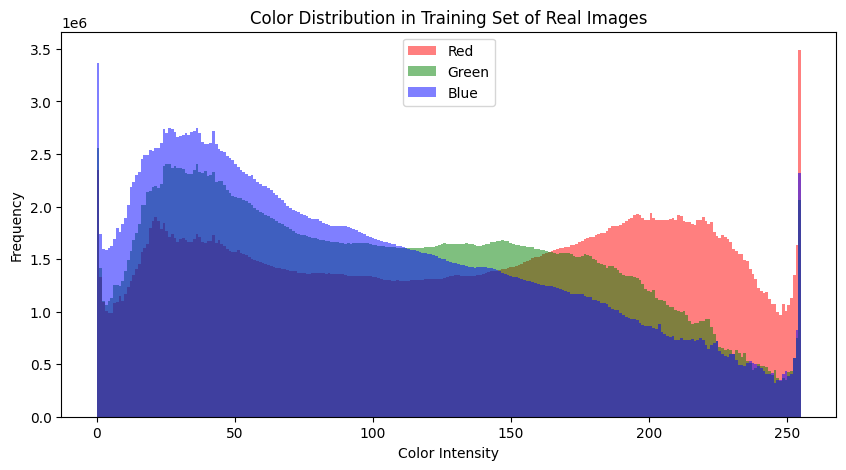

Mean of Color Channels: [130.28472304 107.95395719  97.18377908]
Standard Deviation of Color Channels: [74.41770951 67.29909761 66.62414132]


In [8]:
REAL_DIR = '/content/drive/MyDrive/Project DNN/F_NN_PRO/data/real_and_fake_face_detection/real_and_fake_face/all/train/real'

image_colors = get_image_colors(REAL_DIR)

plt.figure(figsize=(10, 5))
plt.hist(image_colors[:, 0], bins=256, alpha=0.5, color='red', label='Red')
plt.hist(image_colors[:, 1], bins=256, alpha=0.5, color='green', label='Green')
plt.hist(image_colors[:, 2], bins=256, alpha=0.5, color='blue', label='Blue')
plt.xlabel('Color Intensity')
plt.ylabel('Frequency')
plt.title('Color Distribution in Training Set of Real Images')
plt.legend()
plt.show()

# Calculate the mean and standard deviation for each channel
channel_means = np.mean(image_colors, axis=0)
channel_stds = np.std(image_colors, axis=0)

print("Mean of Color Channels:", channel_means)
print("Standard Deviation of Color Channels:", channel_stds)


## Edge detection visualization

Clarity and sharpness of the edges detected in the fake and real images can be indicator of the quality and authenticity of the images. For instance, fake images might show more pronounced or less natural edges due to digital manipulation.

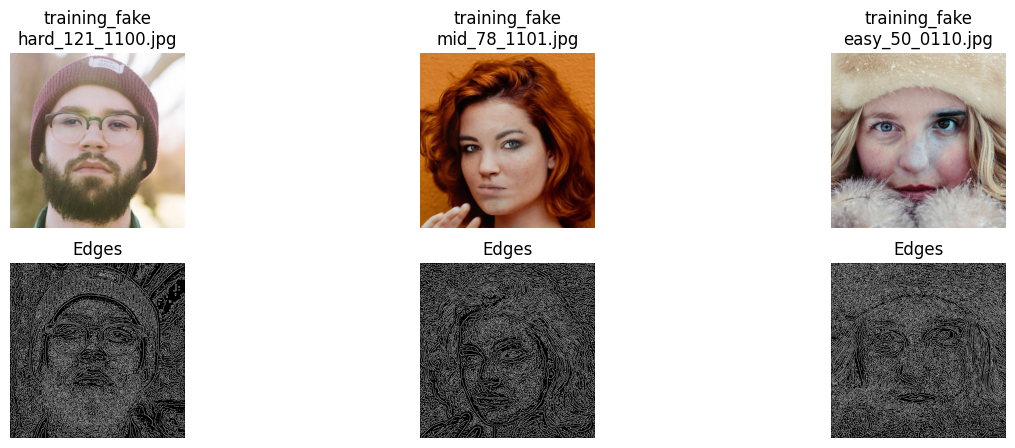

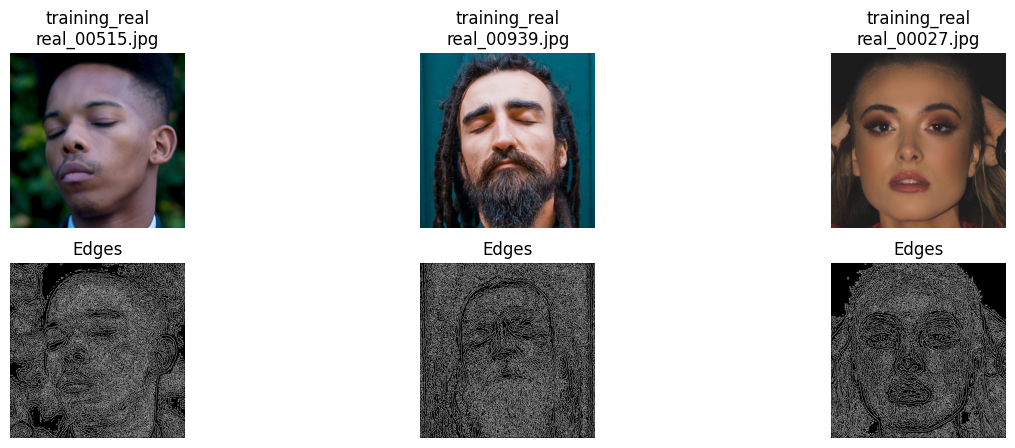

In [9]:
from skimage import feature, io
import numpy as np
import matplotlib.pyplot as plt
import os
import random

def visualize_edges(root_dir, new_root, class_name, num_samples=3, sigma=1.0):
    class_name = f'training_{class_name}'
    class_path = os.path.join(root_dir, new_root, 'train', class_name.split("_")[1])
    sample_files = random.sample(os.listdir(class_path), num_samples)

    plt.figure(figsize=(15, 5))
    for i, file_name in enumerate(sample_files):
        img_path = os.path.join(class_path, file_name)
        img = io.imread(img_path)

        # Convert to grayscale for edge detection
        # Ensure the image is in the correct format
        if img.ndim == 3 and img.shape[2] >= 3:  # Check for color image
            gray_img = np.mean(img[..., :3], axis=2)
        else:
            gray_img = img  # Assume the image is already grayscale

        # Apply Canny edge detector
        edges = feature.canny(gray_img, sigma=sigma)

        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f'{class_name}\n{file_name}')
        plt.axis('off')

        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(edges, cmap='gray')
        plt.title('Edges')
        plt.axis('off')

    plt.show()

ROOT_DIR = '/content/drive/MyDrive/Project DNN/F_NN_PRO/data/real_and_fake_face_detection/real_and_fake_face/'
NEW_ROOT = 'all/'

# Visualize random sample of images from both classes
visualize_edges(ROOT_DIR, NEW_ROOT, 'fake')
visualize_edges(ROOT_DIR, NEW_ROOT, 'real')


- The density of edges within the regions such as hair and facial features give us an idea about textures and level of detail in the images. A high density of edges in real images indicates a complex texture which is a feature that helps to distinguish between fake and real images.

- Edges, detected in the background - compared to the faces, help in understanding the distinction between subject and non-subject elements in the images. A clear separation might be useful for model, as fake images tend to have less distinguished separation between

## Local Binary Pattern (LBP)

Analyzis of textures and patterns in the images.
Provides insights into the complexity of the images and potential challenges for classification models. Local Binary Patterns (LBP) are used to quantify and visualize these aspects.

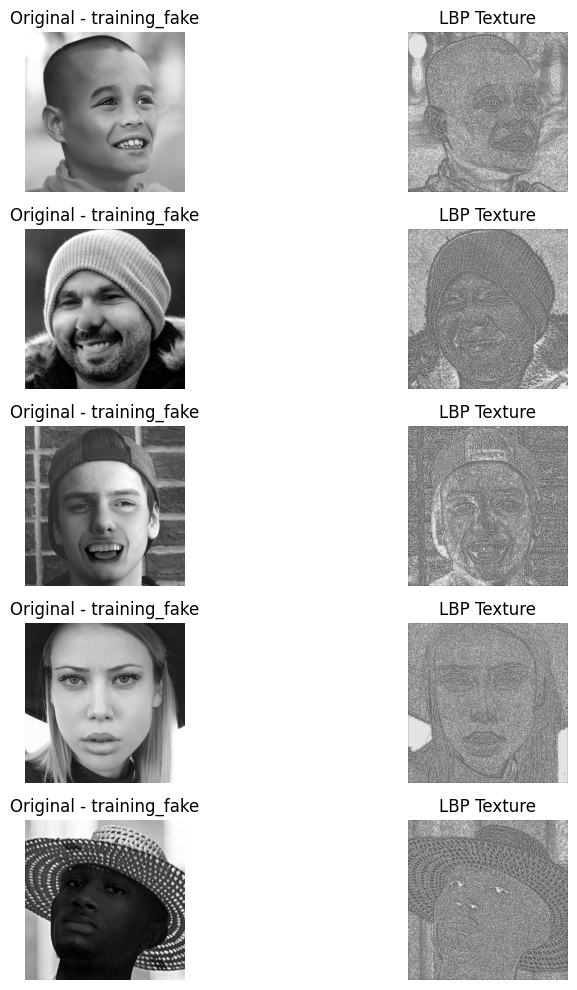

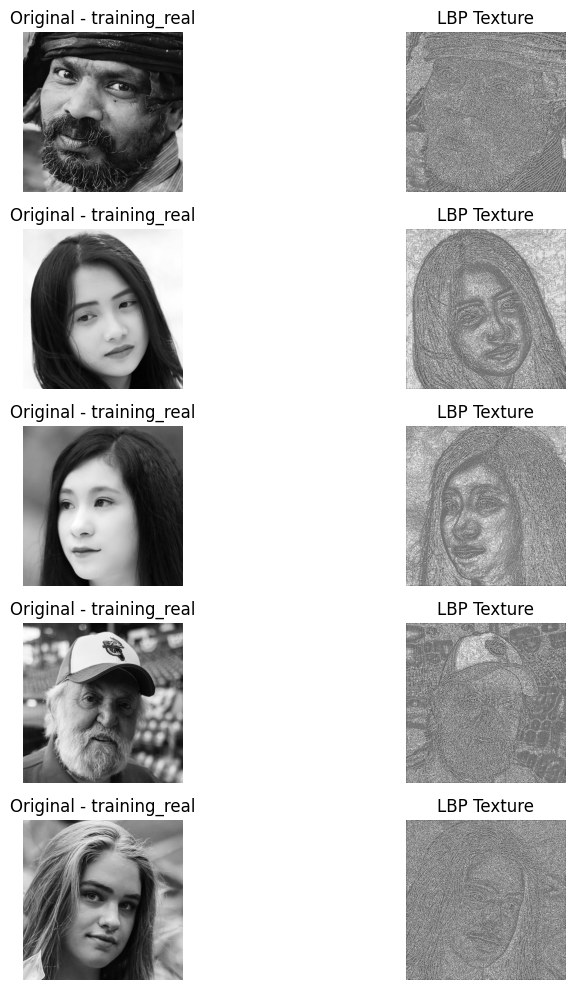

In [10]:
from skimage.feature import local_binary_pattern
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

def analyze_texture_patterns(root_dir, new_root, classes, num_samples=5):
    for class_name in classes:
        class_path = os.path.join(root_dir, new_root, 'train', class_name.split("_")[1])
        files = os.listdir(class_path)
        sampled_files = random.sample(files, min(len(files), num_samples))

        plt.figure(figsize=(10, num_samples * 2))
        for i, file_name in enumerate(sampled_files):
            img_path = os.path.join(class_path, file_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            lbp = local_binary_pattern(img, P=8, R=1, method="uniform")

            plt.subplot(num_samples, 2, i * 2 + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'Original - {class_name}')
            plt.axis('off')

            plt.subplot(num_samples, 2, i * 2 + 2)
            plt.imshow(lbp, cmap='gray')
            plt.title('LBP Texture')
            plt.axis('off')

        plt.tight_layout()
    plt.show()


ROOT_DIR = '/content/drive/MyDrive/Project DNN/F_NN_PRO/data/real_and_fake_face_detection/real_and_fake_face/'
NEW_ROOT = 'all/'
CLASSES = ['training_fake', 'training_real']

analyze_texture_patterns(ROOT_DIR, NEW_ROOT, CLASSES)



- The LBP textures for fakes appears to have a slightly different pattern density and edge sharpness - compared to the real images which might indicate differences in texture between fake and real faces

- There is a visible contrast in the LBP images of real between different facial regions such as hair, skin and background. This contrast is useful for machine learning models to identify and learn distinguishing features

- fake images show more uniform patterns due to digital manipulation, while real images display more natural variability

# DataLoaders Creation

0
torch.Size([128, 128, 3])


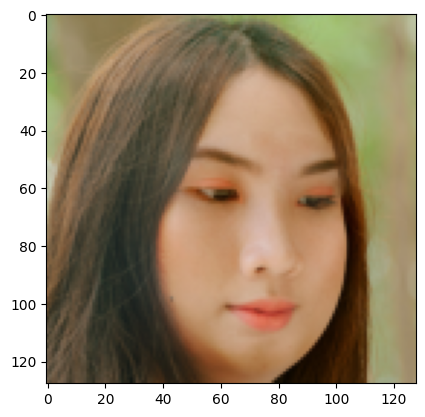

In [11]:
class ImageDataset(Dataset):

    def __init__(self, image_dir):
        """Here we initialize the attributes of the object of the class."""
        self.image_dir = image_dir
        self.image_files = sorted(self._find_files(image_dir))
        self.image_labels = sorted(self._find_labels(image_dir))

    def __len__(self):
        """Here we return the size of the dataset."""
        return len(self.image_files)

    def __getitem__(self, index):
        """Here we return a data sample (image, label) for a given index."""
        x = io.imread(self.image_files[index])
        x = transform.resize(x, (128,128))
        x = torch.tensor(x,dtype=float)
        y = self.image_labels[index]
        return x, y

    def _find_files(self, directory, pattern='*.jpg'):
        """Recursively finds all files matching the pattern."""
        files = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                files.append(os.path.join(root, filename))
        return files

    def _find_labels(self, directory, pattern='*.jpg'):
        classes = [d.name for d in os.scandir(directory) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        labels = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                labels.append(os.path.split(root)[1])
        l = list(map(class_to_idx.get, labels))
        return l


# Initialize the train / test / val datasets by providing the directories to the image corpus data
train_dir = root_dir+'/all/train'
test_dir = root_dir+'/all/test'
val_dir = root_dir+'/all/val'

train_dataset = ImageDataset(image_dir=train_dir)
test_dataset = ImageDataset(image_dir=test_dir)
val_dataset = ImageDataset(image_dir=val_dir)


images_list = train_dataset._find_files(train_dir)

# Load the image with index '0' from the train dataset, print its label, its shape and display it
image, label = train_dataset.__getitem__(0)
print(label)
print(image.shape)
plt.imshow(image)
plt.show()

# Create dataloaders, which sample over the train / test / val datasets with a batch size of 64
batch_size = 64
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

# MLP Classifier

In [12]:
# Define an MLP classifier model with two layers and a non-linear activation function
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super(MLPClassif, self).__init__()

        # define the two linear layers and the activation function
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.activation_fn = act_fn

    def forward(self, x):

        # 'forward' method which computes the output y from the input x
        # apply: layer1, activation function, layer 2, and activation function again
        h = self.layer1(x)
        h = self.activation_fn(h)
        h = self.layer2(h)
        y = self.activation_fn(h)

        return y

## Hyperparameters without Validation

In [13]:
# Hyperparameters to create an instance of the model
input_size = train_dataset[0][0].shape[0]*train_dataset[0][0].shape[1]*train_dataset[0][0].shape[2]
hidden_size = 100
act_fn = nn.Sigmoid()
output_size = len(classes)

# Parameters to train the mlp classifier
num_epochs = 10
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Instanciate the model
model = MLPClassif(input_size, hidden_size, output_size, act_fn)

# Display the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

Total number of parameters:  4915502


## Training without Validation

In [14]:
# Training function: process batches of data at each epoch
def training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True):

    # Copy the model to the device and set it in 'training' mode (thus all gradients are computed)
    model = model.to(device)
    model.train()

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []

    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0

        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):

            # Prepare the inputs (vectorize images) and labels
            images = images.reshape(images.shape[0], -1)

            # Copy the data (images and labels) to the device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            labels_predicted = model(images.float())

            # Backpropagation: compute the gradients and apply the gradient descent algorithm
            loss = loss_fn(labels_predicted, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Add the batch loss to the current epoch loss to update the loss
            loss_current_epoch += loss.item()

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))

    return model, loss_all_epochs

In [15]:
model, loss_all_epochs = training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, device)

Epoch [1/10], Loss: 23.3868
Epoch [2/10], Loss: 22.1661
Epoch [3/10], Loss: 22.1510
Epoch [4/10], Loss: 22.1273
Epoch [5/10], Loss: 22.1405
Epoch [6/10], Loss: 22.1427
Epoch [7/10], Loss: 22.1468
Epoch [8/10], Loss: 22.1305
Epoch [9/10], Loss: 22.1371
Epoch [10/10], Loss: 22.1287


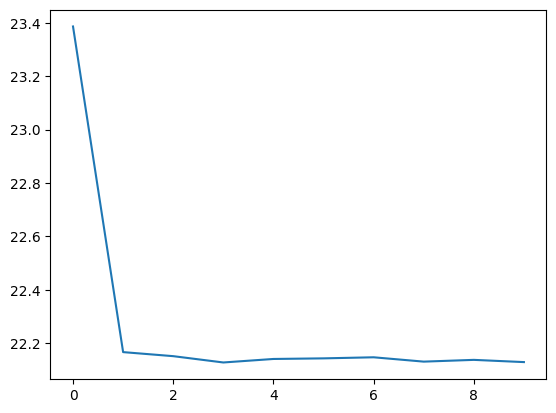

In [16]:
# Display the loss over epochs
plt.plot(loss_all_epochs)
plt.show()

This graph indicates that during the training of a machine learning model, the loss decreases significantly between the first and second epochs, suggesting initial learning. However, from the third epoch onwards, the loss value plateaus with very minor fluctuations, indicating the model is not improving further. This behavior suggests that the model may have reached its learning capacity with the given architecture, data, and hyperparameters.

## Evalution without Validation

In [17]:
# Evaluation function
def eval_mlp_classifier(model, eval_dataloader, device='cpu'):

    # Copy the model to the device
    model.to(device)
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval()

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0

        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels classes
            images = images.reshape(images.shape[0], -1).to(device)
            labels = labels.to(device)
            y_predicted = model(images.float())

            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)

            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()

    accuracy = 100 * correct_labels / total_labels

    return accuracy

In [18]:
# Evaluate the model on the test set and display the accuracy
accuracy = eval_mlp_classifier(model, test_dataloader, device)
print('Accuracy of the network on the test images: ', accuracy, '%')

Accuracy of the network on the test images:  53.04054054054054 %


## Hyperparameter With Validation

In [19]:
# Hyperparameters to create an instance of the model
input_size = train_dataset[0][0].shape[0]*train_dataset[0][0].shape[1]*train_dataset[0][0].shape[2]
hidden_size = 100
act_fn = nn.Sigmoid()
output_size = len(classes)

# Parameters to train the mlp classifier
num_epochs = 10
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Instanciate the model
model_val = MLPClassif(input_size, hidden_size, output_size, act_fn)

# Display the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model_val.parameters()))

Total number of parameters:  4915502


## Training with Validation

In [20]:
# Training function with validation
def train_val_mlp_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, device='cuda'):

    # Copy the model to the device and set it in 'training' mode (thus all gradients are computed)
    model = model.to(device)
    model.train()

    # Define the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Initialize a list to record the training loss and validation accuracy over epochs
    loss_all_epochs = []
    accuracy_val_all_epochs = []

    # Initialize the "optimal" accuracy, which will be used for performing validation
    accuracy_opt = 0

    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0

        # Iterate over batches (using the dataloader)
        for batch_index, (images, labels) in enumerate(train_dataloader):

            # Vectorize the images and copy the data to the device
            images = images.reshape(-1, input_size)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            labels_predicted = model(images.float())
            loss = loss_fn(labels_predicted, labels)

            # Gradient descent
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Add the batch loss to the current epoch loss
            loss_current_epoch += loss.item()

        # At the end of each epoch, record the loss over all batches and the accuracy on the validation set
        loss_all_epochs.append(loss_current_epoch)
        accuracy_current_epoch = eval_mlp_classifier(model, valid_dataloader, device)
        accuracy_val_all_epochs.append(accuracy_current_epoch)

        # Display the training loss and validation accuracy
        print('Epoch [{}/{}], Training loss: {:.4f} ; Validation accuracy: {:.4f}'
               .format(epoch+1, num_epochs, loss_current_epoch, accuracy_current_epoch))

        # Now record the model if the accuracy is higher than the "optimal" value
        if accuracy_current_epoch > accuracy_opt:
            model_opt = model
            accuracy_opt = accuracy_current_epoch

    return model_opt, loss_all_epochs, accuracy_val_all_epochs

In [21]:
# Train the MLP classifier model with validation
model_val, loss_all_epochs, accuracy_validation = train_val_mlp_classifier(model_val, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, device)

Epoch [1/10], Training loss: 22.1242 ; Validation accuracy: 53.7095
Epoch [2/10], Training loss: 22.1204 ; Validation accuracy: 53.7095
Epoch [3/10], Training loss: 22.1193 ; Validation accuracy: 53.7095
Epoch [4/10], Training loss: 22.1138 ; Validation accuracy: 53.7095
Epoch [5/10], Training loss: 22.1107 ; Validation accuracy: 53.7095
Epoch [6/10], Training loss: 22.1063 ; Validation accuracy: 53.7095
Epoch [7/10], Training loss: 22.1031 ; Validation accuracy: 53.7095
Epoch [8/10], Training loss: 22.1006 ; Validation accuracy: 53.7095
Epoch [9/10], Training loss: 22.0976 ; Validation accuracy: 53.7095
Epoch [10/10], Training loss: 22.0947 ; Validation accuracy: 53.7095


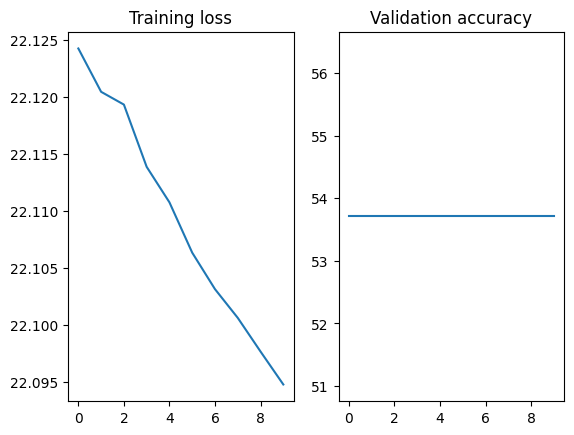

In [22]:
# Display the training loss and validation accuracy over epochs
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.plot(loss_all_epochs)
plt.title('Training loss')
plt.subplot(1, 2, 2)
plt.plot(accuracy_validation)
plt.title('Validation accuracy')
plt.show()

The graph provided represents the training loss and validation accuracy over 10 epochs of a machine learning model training process. The left plot shows the training loss decreasing steadily from approximately 22.1242 to 22.0947, indicating that the model is learning and improving its performance on the training dataset over time. This is a typical behavior during training, where the objective is to minimize loss. On the right plot, however, the validation accuracy remains completely flat at 53.7095% throughout all epochs, which suggests that the model is not improving its performance on the validation dataset. Which is a sign of underfitting.

## Evaluation with Validation

In [23]:
# Evaluate the model on the test set and display the accuracy
accuracy = eval_mlp_classifier(model_val, test_dataloader, device)
print('Accuracy of the network on the test images: ', accuracy, '%')

Accuracy of the network on the test images:  53.04054054054054 %


# Model Saving

In [24]:
# Save the model parameters
torch.save(model.state_dict(), 'model_mlp_classif_val'+'b'+str(batch_size)+'h'+str(hidden_size)+'e'+str(num_epochs)+'.pt')

In [25]:
# Save the figure with the training loss and validation accuracy over epochs
fig.savefig('results'+'b'+str(batch_size)+'h'+str(hidden_size)+'e'+str(num_epochs)+'_val'+'.png')